# **Application SEIR-PINN**


# Table des matières

I. [Contexte et objectifs de l'identification SEIR par PINNs](#i-contexte-et-objectifs-de-lidentification-seir-par-pinns)  
II. [Importation des bibliothèques](#ii-importation-des-bibliothèques)  
III. [Données simulées par RK4](#iii-données-simulées-par-rk4)  

IV. [Approche conjointe PINN](#iv-approche-conjointe-pinn)  
 IV.1. [Données complètes – Entraînement PINN conjoint](#iv1-données-complètes--entraînement-pinn-conjoint)  
 IV.2. [Données partielles – Entraînement PINN conjoint](#iv2-données-partielles--entraînement-pinn-conjoint)  

V. [Approche Split-PINN](#v-approche-split-pinn)  
 V.1. [Données partielles – Entraînement Split-PINN](#v1-données-partielles--entraînement-split-pinn)  

VI. [Données réelles – COVID Maroc](#vi-données-réelles--covid-maroc)  
 VI.1. [Application aux données réelles – Entraînement Split-PINN](#vi1-application-aux-données-réelles--entraînement-split-pinn)  

VII. [Bilan et analyse des approches](#vii-bilan-et-analyse-des-approches)


## I. Contexte et objectifs de l'identification SEIR par PINNs

Dans ce notebook, nous appliquons concrètement la méthode des réseaux de neurones informés par la physique (PINNs) au modèle épidémique SEIR.

L’objectif est de valider l'efficacité des PINNs pour :
- estimer les **paramètres du modèle SEIR** (\(\beta, \sigma, \lambda\)),
- reconstruire les **compartiments dynamiques** \(S(t), E(t), I(t), R(t)\),
- en se basant uniquement sur les **données simulées de la variable infectée \(I(t)\)**.

Nous considérons ici une phase de validation numérique, en générant des données synthétiques à partir du schéma de Runge-Kutta (RK4), pour lesquelles les trajectoires exactes sont connues. Cela nous permet d’évaluer précisément la qualité des prédictions du réseau PINN.

Nous comparerons deux approches :
- une **approche conjointe**, où les paramètres et les états sont estimés simultanément,
- une **approche Split-PINN**, qui découple l’estimation du facteur de sous-détection \(k\) et celle des autres paramètres.

Les résultats obtenus seront comparés aux solutions de référence issues du RK4, afin d’évaluer la capacité du modèle à  la dynamique réelle du système.

## II. Importation des bibliothèques

In [ ]:
#Importation des bibliothèques
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import mean_absolute_error, r2_score
from google.colab import files
import pathlib

## III. Données simulées par RK4


In [ ]:
# -----------------------------------------------------------------
# 0. Paramètres « réels » et conditions initiales
# -----------------------------------------------------------------
beta_true, sigma_true, lambda_true = 0.50, 0.33, 0.16
S0, E0, I0, R0                     = 0.96, 0.02, 0.02, 0.00
t0, T_final, dt                    = 0.0, 150.0, 0.1

In [ ]:
def seir_rhs(S, E, I, R):
    dS = -beta_true * S * I
    dE =  beta_true * S * I - sigma_true * E
    dI =  sigma_true * E     - lambda_true * I
    dR =  lambda_true * I
    return dS, dE, dI, dR

t, S, E, I, R = [t0], [S0], [E0], [I0], [R0]
while t[-1] < T_final:
    S_l, E_l, I_l, R_l = S[-1], E[-1], I[-1], R[-1]
    k1 = seir_rhs(S_l,                     E_l,                     I_l,                     R_l)
    k2 = seir_rhs(S_l+dt*k1[0]/2,          E_l+dt*k1[1]/2,          I_l+dt*k1[2]/2,          R_l+dt*k1[3]/2)
    k3 = seir_rhs(S_l+dt*k2[0]/2,          E_l+dt*k2[1]/2,          I_l+dt*k2[2]/2,          R_l+dt*k2[3]/2)
    k4 = seir_rhs(S_l+dt*k3[0],            E_l+dt*k3[1],            I_l+dt*k3[2],            R_l+dt*k3[3])
    S.append(S_l + dt/6*(k1[0]+2*k2[0]+2*k3[0]+k4[0]))
    E.append(E_l + dt/6*(k1[1]+2*k2[1]+2*k3[1]+k4[1]))
    I.append(I_l + dt/6*(k1[2]+2*k2[2]+2*k3[2]+k4[2]))
    R.append(R_l + dt/6*(k1[3]+2*k2[3]+2*k3[3]+k4[3]))
    t.append(t[-1] + dt)


In [ ]:
df = pd.DataFrame({"Temps": t, "S": S, "E": E, "I": I, "R": R})

In [ ]:
print("Aperçu des données simulées :")
display(df.head(10))

Aperçu des données simulées :


,Temps,S,E,I,R
0,0.0,0.960000,0.020000,0.020000,0.000000
1,0.1,0.959032,0.020303,0.020342,0.000323
2,0.2,0.958049,0.020611,0.020689,0.000651
3,0.3,0.957050,0.020925,0.021041,0.000985
4,0.4,0.956035,0.021244,0.021397,0.001324
5,0.5,0.955004,0.021568,0.021758,0.001670
6,0.6,0.953957,0.021898,0.022124,0.002021
7,0.7,0.952894,0.022233,0.022495,0.002378
8,0.8,0.951814,0.022574,0.022872,0.002740
9,0.9,0.950717,0.022920,0.023253,0.003109


In [ ]:
df.to_csv("seir_simulation.csv", index=False)

## IV. Approche conjointe PINN

### IV.1. Données complètes – Entraînement PINN conjoint

In [ ]:
class SEIR_PINN(tf.keras.Model):
    def __init__(self, width=50, depth=3, seed=123):
        super().__init__()
        tf.random.set_seed(seed)

        # réseau fully-connected
        layers = [tf.keras.layers.InputLayer((1,))]
        layers += [tf.keras.layers.Dense(width, activation="tanh") for _ in range(depth)]
        layers.append(tf.keras.layers.Dense(4, activation=None))
        self.net = tf.keras.Sequential(layers)

        # paramètres physiques trainables
        rnd = tf.keras.initializers.RandomUniform(0.1, 0.8)
        self.beta   = self.add_weight(name="beta",   shape=(), initializer=rnd, trainable=True)
        self.sigma  = self.add_weight(name="sigma",  shape=(), initializer=rnd, trainable=True)
        self.lmbda  = self.add_weight(name="lambda", shape=(), initializer=rnd, trainable=True)

    def call(self, t):
        return self.net(t)

In [ ]:
@tf.function
def pinn_loss(model, t, S_obs, E_obs, I_obs, R_obs):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        S_p, E_p, I_p, R_p = tf.split(model(t), 4, axis=1)
        dSdt = tape.gradient(S_p, t)
        dEdt = tape.gradient(E_p, t)
        dIdt = tape.gradient(I_p, t)
        dRdt = tape.gradient(R_p, t)
        #Calcul des résidus des équations SEIR
        f1 = dSdt + model.beta  * S_p * I_p
        f2 = dEdt - (model.beta * S_p * I_p - model.sigma * E_p)
        f3 = dIdt - (model.sigma* E_p - model.lmbda * I_p)
        f4 = dRdt - model.lmbda * I_p

    mse_data = tf.reduce_mean((S_p - S_obs)**2 +
                              (E_p - E_obs)**2 +
                              (I_p - I_obs)**2 +
                              (R_p - R_obs)**2)
    mse_phys = tf.reduce_mean(f1**2 + f2**2 + f3**2 + f4**2)
    return mse_data + mse_phys

In [ ]:
# Données TensorFlow
t_tf = df[["Temps"]].values.astype(np.float32)
S_tf = df[["S"]].values.astype(np.float32)
E_tf = df[["E"]].values.astype(np.float32)
I_tf = df[["I"]].values.astype(np.float32)
R_tf = df[["R"]].values.astype(np.float32)

In [ ]:
model = SEIR_PINN()
opt   = tf.keras.optimizers.Adam(1e-3)

EPOCHS = 5000

In [ ]:
hist_b, hist_s, hist_l = [], [], []

for k in range(EPOCHS + 1):
    with tf.GradientTape() as tape:
        L = pinn_loss(model, t_tf, S_tf, E_tf, I_tf, R_tf)
    grads = tape.gradient(L, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))

    hist_b.append(model.beta.numpy())
    hist_s.append(model.sigma.numpy())
    hist_l.append(model.lmbda.numpy())

    if k % 500 == 0:
        print(f"[{k:4d}] loss={L.numpy():.3e}  β={hist_b[-1]:.4f}  σ={hist_s[-1]:.4f}  λ={hist_l[-1]:.4f}")

print("\nEstimation finale  β={:.5f}  σ={:.5f}  λ={:.5f}"
      .format(model.beta.numpy(), model.sigma.numpy(), model.lmbda.numpy()))


[   0] loss=4.811e-01  β=0.2323  σ=0.2303  λ=0.2303
[ 500] loss=4.464e-04  β=0.3992  σ=0.2408  λ=0.1402
[1000] loss=1.931e-04  β=0.4459  σ=0.2771  λ=0.1495
[1500] loss=1.297e-04  β=0.4631  σ=0.3033  λ=0.1535
[2000] loss=9.479e-05  β=0.4775  σ=0.3172  λ=0.1585
[2500] loss=6.898e-05  β=0.4874  σ=0.3250  λ=0.1600
[3000] loss=5.565e-05  β=0.4870  σ=0.3239  λ=0.1597
[3500] loss=4.393e-05  β=0.4897  σ=0.3259  λ=0.1599
[4000] loss=3.659e-05  β=0.4911  σ=0.3264  λ=0.1598
[4500] loss=2.754e-04  β=0.4922  σ=0.3267  λ=0.1548
[5000] loss=2.670e-05  β=0.4918  σ=0.3260  λ=0.1596

Estimation finale  β=0.49180  σ=0.32601  λ=0.15958


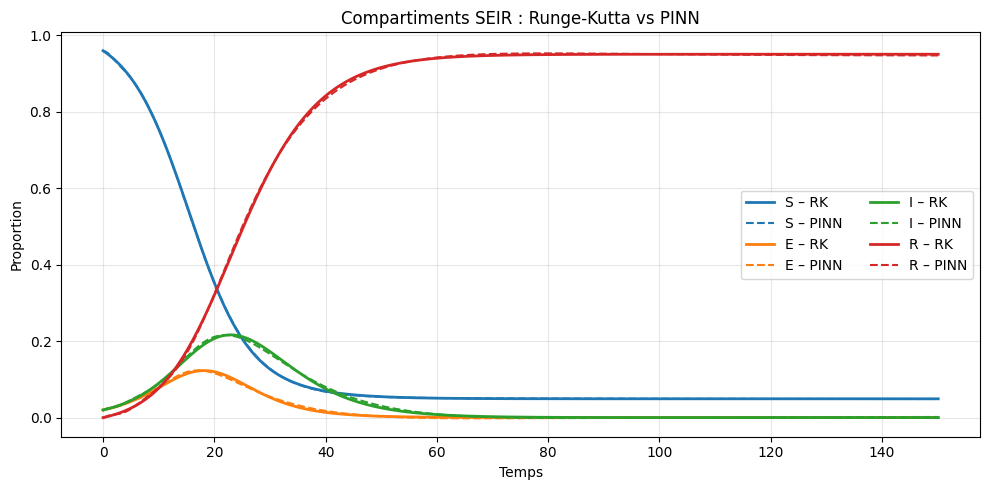

In [ ]:
# -----------------------------------------------------------------
# 3. Visualisation des compartiments
# -----------------------------------------------------------------
S_pred, E_pred, I_pred, R_pred = tf.split(model(t_tf), 4, axis=1)
cS, cE, cI, cR = "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"

plt.figure(figsize=(10,5))
plt.plot(t, S, cS, lw=2, label="S – RK"); plt.plot(t, S_pred, cS, ls="--", lw=1.5, label="S – PINN")
plt.plot(t, E, cE, lw=2, label="E – RK"); plt.plot(t, E_pred, cE, ls="--", lw=1.5, label="E – PINN")
plt.plot(t, I, cI, lw=2, label="I – RK"); plt.plot(t, I_pred, cI, ls="--", lw=1.5, label="I – PINN")
plt.plot(t, R, cR, lw=2, label="R – RK"); plt.plot(t, R_pred, cR, ls="--", lw=1.5, label="R – PINN")
plt.title("Compartiments SEIR : Runge-Kutta vs PINN")
plt.xlabel("Temps"); plt.ylabel("Proportion"); plt.grid(alpha=0.3)
plt.legend(ncol=2); plt.tight_layout(); plt.show()


In [ ]:
# --------------------------------------------
# Style graphique
# --------------------------------------------
sns.set_theme(style="white", context="talk", palette="colorblind")

plt.rcParams["figure.facecolor"] = "#f2f2f2"
plt.rcParams["axes.facecolor"]   = "#f2f2f2"
plt.rcParams["axes.edgecolor"]   = "lightgray"
plt.rcParams["axes.linewidth"]   = 1.0
plt.rc("font",   family="serif", weight="light")
plt.rc("axes",   titlesize=13, labelsize=11)
plt.rc("legend", fontsize=9, handlelength=1, handletextpad=0.5, borderpad=0.4)
plt.rc("xtick",  labelsize=10)
plt.rc("ytick",  labelsize=10)

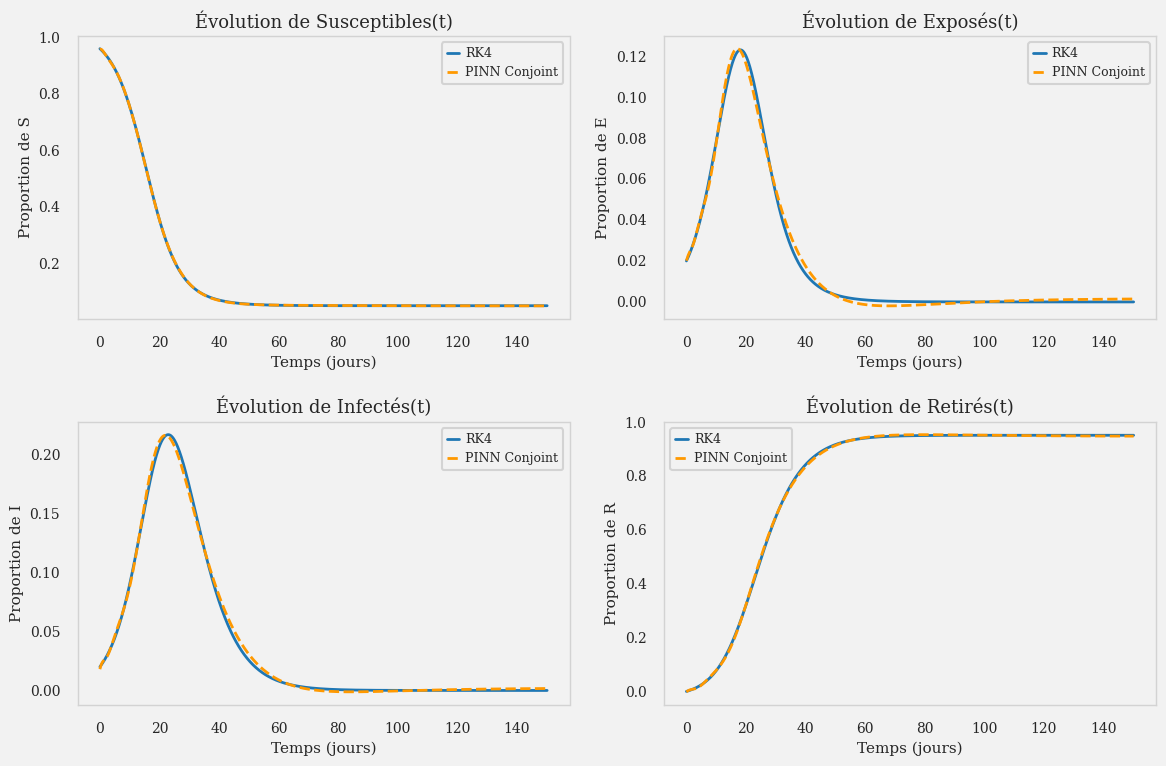

In [ ]:
# --------------------------------------------
# Prédictions PINN (conjointes)
# --------------------------------------------
S_pred, E_pred, I_pred, R_pred = tf.split(model(t_tf), 4, axis=1)

# --------------------------------------------
# Création des sous-figures (2x2)
# --------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Couleurs
rk4_color = "#1f77b4"  # bleu
pinn_color = "#ff9900"  # orange foncé

#  S(t)
axs[0, 0].plot(t, S,      color=rk4_color, lw=2, label="RK4")
axs[0, 0].plot(t, S_pred, color=pinn_color, lw=2, ls="--", label="PINN Conjoint")
axs[0, 0].set_title("Évolution de Susceptibles(t)")
axs[0, 0].set_ylabel("Proportion de S")
axs[0, 0].set_xlabel("Temps (jours)")
axs[0, 0].legend()
axs[0, 0].grid(False)

#  E(t)
axs[0, 1].plot(t, E,      color=rk4_color, lw=2, label="RK4")
axs[0, 1].plot(t, E_pred, color=pinn_color, lw=2, ls="--", label="PINN Conjoint")
axs[0, 1].set_title("Évolution de Exposés(t)")
axs[0, 1].set_ylabel("Proportion de E")
axs[0, 1].set_xlabel("Temps (jours)")
axs[0, 1].legend()
axs[0, 1].grid(False)

# I(t)
axs[1, 0].plot(t, I,      color=rk4_color, lw=2, label="RK4")
axs[1, 0].plot(t, I_pred, color=pinn_color, lw=2, ls="--", label="PINN Conjoint")
axs[1, 0].set_title("Évolution de Infectés(t)")
axs[1, 0].set_ylabel("Proportion de I")
axs[1, 0].set_xlabel("Temps (jours)")
axs[1, 0].legend()
axs[1, 0].grid(False)

#  R(t)
axs[1, 1].plot(t, R,      color=rk4_color, lw=2, label="RK4")
axs[1, 1].plot(t, R_pred, color=pinn_color, lw=2, ls="--", label="PINN Conjoint")
axs[1, 1].set_title("Évolution de Retirés(t)")
axs[1, 1].set_ylabel("Proportion de R")
axs[1, 1].set_xlabel("Temps (jours)")
axs[1, 1].legend()
axs[1, 1].grid(False)

plt.tight_layout()
# ✅ Sauvegarde de la figure
plt.savefig("comparaison_SEIR_PINN_vs_RK4.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

In [ ]:
from google.colab import files
files.download("comparaison_SEIR_PINN_vs_RK4.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### IV.2. Données partielles – Entraînement PINN conjoint


In [ ]:
# --------------------------------------------
# Importations et configuration du style
# --------------------------------------------
sns.set_theme(
    style="white",        # fond uni
    context="talk",       # textes plus lisibles
    palette="colorblind"  # palette accessible
)

# Fond gris clair pour figure et axes
plt.rcParams["figure.facecolor"] = "#f2f2f2"
plt.rcParams["axes.facecolor"]   = "#f2f2f2"
plt.rcParams["axes.edgecolor"]   = "lightgray"
plt.rcParams["axes.linewidth"]   = 1.0

# Tailles et styles de police
plt.rc("font",   family="serif", weight="light")
plt.rc("axes",   titlesize=12, labelsize=12)
plt.rc("legend", fontsize=9, handlelength=0.8, handletextpad=0.3, borderpad=0.3)
plt.rc("xtick",  labelsize=10)
plt.rc("ytick",  labelsize=10)


In [ ]:
df = pd.read_csv("seir_simulation.csv")
# Pour l'entraînement, on ne conserve que Temps et I
t_list = df["Temps"].tolist()
I_list = df["I"].tolist()
# Tensores pour TensorFlow
t_tf = df[["Temps"]].values.astype(np.float32)
I_tf = df[["I"]    ].values.astype(np.float32)

In [ ]:
# ─────────────────────────────────────────────────────────────
# 1. Conjoint-PINN
# ─────────────────────────────────────────────────────────────
class SEIR_Conjoint_PINN(tf.keras.Model):
    def __init__(self, width=50, depth=3, seed=123):
        super().__init__()
        tf.random.set_seed(seed)
        layers = [tf.keras.layers.InputLayer((1,))]
        for _ in range(depth):
            layers.append(tf.keras.layers.Dense(width, activation="tanh"))
        layers.append(tf.keras.layers.Dense(4, activation=None))
        self.net = tf.keras.Sequential(layers)
        rnd = tf.keras.initializers.RandomUniform(0.1, 0.8)
        self.beta  = self.add_weight(shape=(), initializer=rnd,
                                     trainable=True, name="beta")
        self.sigma = self.add_weight(shape=(), initializer=rnd,
                                     trainable=True, name="sigma")
        self.lmbda = self.add_weight(shape=(), initializer=rnd,
                                     trainable=True, name="lambda")

    def call(self, t):
        return self.net(t)
@tf.function
def pinn_loss_conjoint(model, t, I_obs):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        S_p, E_p, I_p, R_p = tf.split(model(t), 4, axis=1)
        dS = tape.gradient(S_p, t)
        dE = tape.gradient(E_p, t)
        dI = tape.gradient(I_p, t)
        dR = tape.gradient(R_p, t)
        f1 = dS + model.beta * S_p * I_p
        f2 = dE - (model.beta * S_p * I_p - model.sigma * E_p)
        f3 = dI - (model.sigma * E_p - model.lmbda * I_p)
        f4 = dR - model.lmbda * I_p
    mse_data = tf.reduce_mean((I_p - I_obs)**2)
    mse_phys = tf.reduce_mean(f1**2 + f2**2 + f3**2 + f4**2)
    return mse_data + mse_phys, mse_data

modelC = SEIR_Conjoint_PINN()
optC   = tf.keras.optimizers.Adam(1e-3)
EPOCHS = 5000

In [ ]:
print("─── Entraînement Conjoint-PINN ───")
for k in range(EPOCHS + 1):
    with tf.GradientTape() as tape:
        lossC, dataC = pinn_loss_conjoint(modelC, t_tf, I_tf)
    grads = tape.gradient(lossC, modelC.trainable_variables)
    optC.apply_gradients(zip(grads, modelC.trainable_variables))
    if k % 500 == 0:
        print(f"[Conjoint {k:4d}] total_loss={lossC.numpy():.3e} "
              f"data_loss={dataC.numpy():.3e} "
              f"β={modelC.beta.numpy():.4f} "
              f"σ={modelC.sigma.numpy():.4f} "
              f"λ={modelC.lmbda.numpy():.4f}")

# prédiction Conjoint
I_pred_C = tf.split(modelC(t_tf), 4, axis=1)[2].numpy().squeeze()


─── Entraînement Conjoint-PINN ───
[Conjoint    0] total_loss=2.156e-01 data_loss=6.220e-03 β=0.3952 σ=0.3952 λ=0.3972
[Conjoint  500] total_loss=1.539e-04 data_loss=1.069e-04 β=0.3987 σ=0.3813 λ=0.1545
[Conjoint 1000] total_loss=6.921e-05 data_loss=5.787e-05 β=0.4027 σ=0.3814 λ=0.0925
[Conjoint 1500] total_loss=4.757e-05 data_loss=3.922e-05 β=0.4044 σ=0.3815 λ=0.0793
[Conjoint 2000] total_loss=1.654e-03 data_loss=1.630e-03 β=0.4130 σ=0.3818 λ=0.0749
[Conjoint 2500] total_loss=3.716e-05 data_loss=3.056e-05 β=0.4263 σ=0.3822 λ=0.0699
[Conjoint 3000] total_loss=3.103e-05 data_loss=2.497e-05 β=0.4483 σ=0.3828 λ=0.0720
[Conjoint 3500] total_loss=2.465e-05 data_loss=1.928e-05 β=0.4768 σ=0.3836 λ=0.0749
[Conjoint 4000] total_loss=1.922e-05 data_loss=1.471e-05 β=0.5088 σ=0.3846 λ=0.0806
[Conjoint 4500] total_loss=1.395e-05 data_loss=1.024e-05 β=0.5407 σ=0.3856 λ=0.0869
[Conjoint 5000] total_loss=9.438e-06 data_loss=6.426e-06 β=0.5678 σ=0.3867 λ=0.0920


In [ ]:
df = pd.DataFrame({
    "Temps": t,
    "S":     S,
     "E":     E,
    "I":     I,
    "R":     R
})
t_list = t
S_list = S
E_list = E
I_list = I
R_list = R

In [ ]:
# --------------------------------------------
# Extraction des trajectoires PINNs
# --------------------------------------------
outsC = modelC(t_tf)
S_C, E_C, I_C, R_C = [x.numpy().squeeze()
                     for x in tf.split(outsC,4,axis=1)]

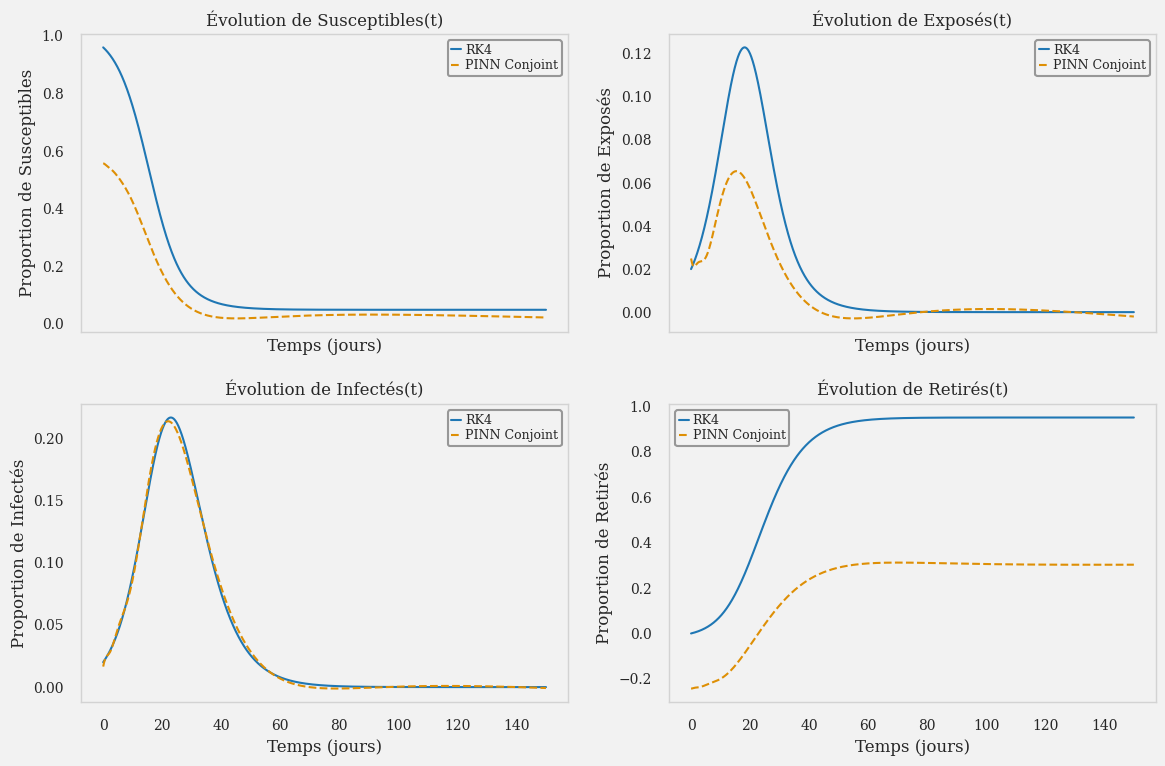

In [ ]:
# --------------------------------------------
#Figure RK4 vs PINN Conjoint
# --------------------------------------------
fig, axs = plt.subplots(2,2,figsize=(12,8), sharex=True)
labels    = ["Susceptibles","Exposés","Infectés","Retirés"]
rk4_vals  = [S_list, E_list, I_list, R_list]
conj_vals = [S_C,    E_C,    I_C,    R_C]

for ax, lab, rk4, cj in zip(axs.ravel(), labels, rk4_vals, conj_vals):
    ax.plot(t_list, rk4,
            color="#1f77b4", linestyle="-", linewidth=1.5, label="RK4")
    ax.plot(t_list, cj,
            color="C1", linestyle="--", linewidth=1.5, label="PINN Conjoint")
    ax.set_title(f"Évolution de {lab}(t)", pad=6)
    ax.set_xlabel("Temps (jours)")
    ax.set_ylabel(f"Proportion de {lab}")
    ax.set_facecolor("#f2f2f2")
    ax.grid(False)
    leg = ax.legend(loc="best", frameon=True,
                    fontsize=9, handlelength=0.8,
                    handletextpad=0.3, borderpad=0.3,
                    labelspacing=0.2)
    leg.get_frame().set_facecolor("none")
    leg.get_frame().set_edgecolor("gray")


plt.tight_layout()
# ✅ Sauvegarde de la figure
plt.savefig("comparaison_SEIR_PINN_vs_RK4_conjoint.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

In [ ]:
from google.colab import files
files.download("comparaison_SEIR_PINN_vs_RK4_conjoint.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## V. Approche Split-PINN

### V.1. Données partielles – Entraînement Split-PINN

In [ ]:
# =========================================================
# Phase A : Apprentissage de l’infecté Î(t)
# =========================================================
tf.keras.backend.set_floatx("float32"); tf.random.set_seed(123)

# 1) Données (t, I)
df   = pd.read_csv("seir_simulation.csv")           # colonnes « Temps », « I »
t_tf = df[["Temps"]].values.astype("float32")
I_tf = df[["I"    ]].values.astype("float32")

# 2) Réseau  ⟶  Î(t)
class PINN_I(tf.keras.Model):
    def __init__(self, width=50, depth=3, seed=123):
        super().__init__()
        tf.random.set_seed(seed)
        layers = [tf.keras.layers.InputLayer((1,))]
        for _ in range(depth):
            layers.append(tf.keras.layers.Dense(width, activation="tanh"))
        layers.append(tf.keras.layers.Dense(1))     # sortie linéaire
        self.net = tf.keras.Sequential(layers)

    def call(self, t):
        return tf.nn.softplus(self.net(t))          # Î ≥ 0

modelA = PINN_I()
optA   = tf.keras.optimizers.Adam(1e-3)
EPOCHS = 4000

print("─── Phase A : entraînement (MSE_I) ───")
for k in range(EPOCHS + 1):
    with tf.GradientTape() as tape:
        I_hat = modelA(t_tf)
        loss  = tf.reduce_mean((I_hat - I_tf)**2)   # L_I (ligne 4 de l’algorithme)
    optA.apply_gradients(zip(tape.gradient(loss, modelA.trainable_variables),
                             modelA.trainable_variables))
    if k % 500 == 0:
        print(f"[A {k:4d}] MSE_I = {loss.numpy():.3e}")

# 3) Î(t) sera ré-utilisé
modelA.trainable = False


─── Phase A : entraînement (MSE_I) ───
[A    0] MSE_I = 5.447e-01
[A  500] MSE_I = 1.517e-03
[A 1000] MSE_I = 7.459e-05
[A 1500] MSE_I = 2.450e-05
[A 2000] MSE_I = 9.593e-06
[A 2500] MSE_I = 8.710e-06
[A 3000] MSE_I = 3.026e-06
[A 3500] MSE_I = 2.222e-06
[A 4000] MSE_I = 1.725e-06


In [ ]:
# =========================================================
# Phase B : Apprentissage de S(t), E(t), R(t), β, σ, γ
# =========================================================

class PINN_SER(tf.keras.Model):
    def __init__(self, width=50, depth=3, seed=123):
        super().__init__()
        tf.random.set_seed(seed)
        layers = [tf.keras.layers.InputLayer((1,))]
        for _ in range(depth):
            layers.append(tf.keras.layers.Dense(width, activation="tanh"))
        layers.append(tf.keras.layers.Dense(3))  # S, E, R
        self.net = tf.keras.Sequential(layers)
        # paramètres dynamiques à estimer
        rnd = tf.keras.initializers.RandomUniform(0.1, 0.8)
        self.beta  = self.add_weight(shape=(), initializer=rnd, trainable=True, name="beta")
        self.sigma = self.add_weight(shape=(), initializer=rnd, trainable=True, name="sigma")
        self.gamma = self.add_weight(shape=(), initializer=rnd, trainable=True, name="gamma")

    def call(self, t):
        return tf.nn.sigmoid(self.net(t))  # borné entre [0,1]

@tf.function
def loss_phaseB(model, t, I_obs, lambda_data=1.0):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)

        # 1. Sorties du réseau B
        S, E, R = tf.split(model(t), 3, axis=1)

        # 2. I_hat = output de modelA, dépend de t
        I_hat = modelA(t)

        # 3. Dérivées temporelles
        dS = tape.gradient(S, t)
        dE = tape.gradient(E, t)
        dR = tape.gradient(R, t)
        dI = tape.gradient(I_hat, t)

        # 4. Résidus SEIR
        fS = dS + model.beta * S * I_hat
        fE = dE - model.beta * S * I_hat + model.sigma * E
        fI = dI - model.sigma * E + model.gamma * I_hat
        fR = dR - model.gamma * I_hat

    # 5. Pertes
    mse_S = tf.reduce_mean(fS**2)
    mse_E = tf.reduce_mean(fE**2)
    mse_I = tf.reduce_mean(fI**2)
    mse_R = tf.reduce_mean(fR**2)
    mse_data = tf.reduce_mean((I_hat - I_obs)**2)  # renfort

    loss_tot = mse_S + mse_E + mse_I + mse_R + lambda_data * mse_data
    return loss_tot, (mse_S, mse_E, mse_I, mse_R, mse_data)

# ─── Initialisation du modèle et optimiseur ──────────────
modelB = PINN_SER()
optB   = tf.keras.optimizers.Adam(1e-3)
EPOCHS_B = 5000

# modelA doit être déjà entraîné en Phase A (et non re-entraîné ici)
modelA.trainable = False


In [ ]:
print("─── Phase B : entraînement Split-PINN ───")
for k in range(EPOCHS_B + 1):
    with tf.GradientTape() as tape:
        Ltot, (LS, LE, LI, LR, Ldata) = loss_phaseB(modelB, t_tf, I_tf, lambda_data=1.0)
    grads = tape.gradient(Ltot, modelB.trainable_variables)
    optB.apply_gradients(zip(grads, modelB.trainable_variables))

    if k % 500 == 0:
        print(f"[B {k:4d}] Ltot={Ltot.numpy():.3e}  "
              f"MSE_I={Ldata.numpy():.3e}  "
              f"β={modelB.beta.numpy():.4f}  "
              f"σ={modelB.sigma.numpy():.4f}  "
              f"γ={modelB.gamma.numpy():.4f}")
# Remarque : Dans ce notebook, le paramètre γ (gamma) est utilisé pour représenter λ (lambda)
# dans le modèle SEIR. Ainsi, lorsque nous faisons référence à γ, cela correspond en fait à λ dans ce contexte spécifique.


─── Phase B : entraînement Split-PINN ───
[B    0] Ltot=5.071e-02  MSE_I=1.725e-06  β=0.3224  σ=0.3204  γ=0.3224
[B  500] Ltot=4.636e-05  MSE_I=1.725e-06  β=0.2710  σ=0.3083  γ=0.0883
[B 1000] Ltot=2.432e-05  MSE_I=1.725e-06  β=0.2716  σ=0.3075  γ=0.0559
[B 1500] Ltot=1.871e-05  MSE_I=1.725e-06  β=0.2832  σ=0.3074  γ=0.0488
[B 2000] Ltot=1.509e-05  MSE_I=1.725e-06  β=0.3153  σ=0.3081  γ=0.0586
[B 2500] Ltot=1.070e-05  MSE_I=1.725e-06  β=0.3760  σ=0.3097  γ=0.0808
[B 3000] Ltot=5.683e-06  MSE_I=1.725e-06  β=0.4560  σ=0.3117  γ=0.1127
[B 3500] Ltot=3.765e-06  MSE_I=1.725e-06  β=0.5145  σ=0.3131  γ=0.1320
[B 4000] Ltot=3.367e-06  MSE_I=1.725e-06  β=0.5430  σ=0.3138  γ=0.1387
[B 4500] Ltot=3.194e-06  MSE_I=1.725e-06  β=0.5548  σ=0.3141  γ=0.1408
[B 5000] Ltot=3.112e-06  MSE_I=1.725e-06  β=0.5594  σ=0.3143  γ=0.1414


In [ ]:
outsB = modelB(t_tf)  # shape = (N, 3)
S_B, E_B, R_B = [x.numpy().squeeze() for x in tf.split(outsB, 3, axis=1)]

I_B = modelA(t_tf).numpy().squeeze()  # I(t) venant de la Phase A


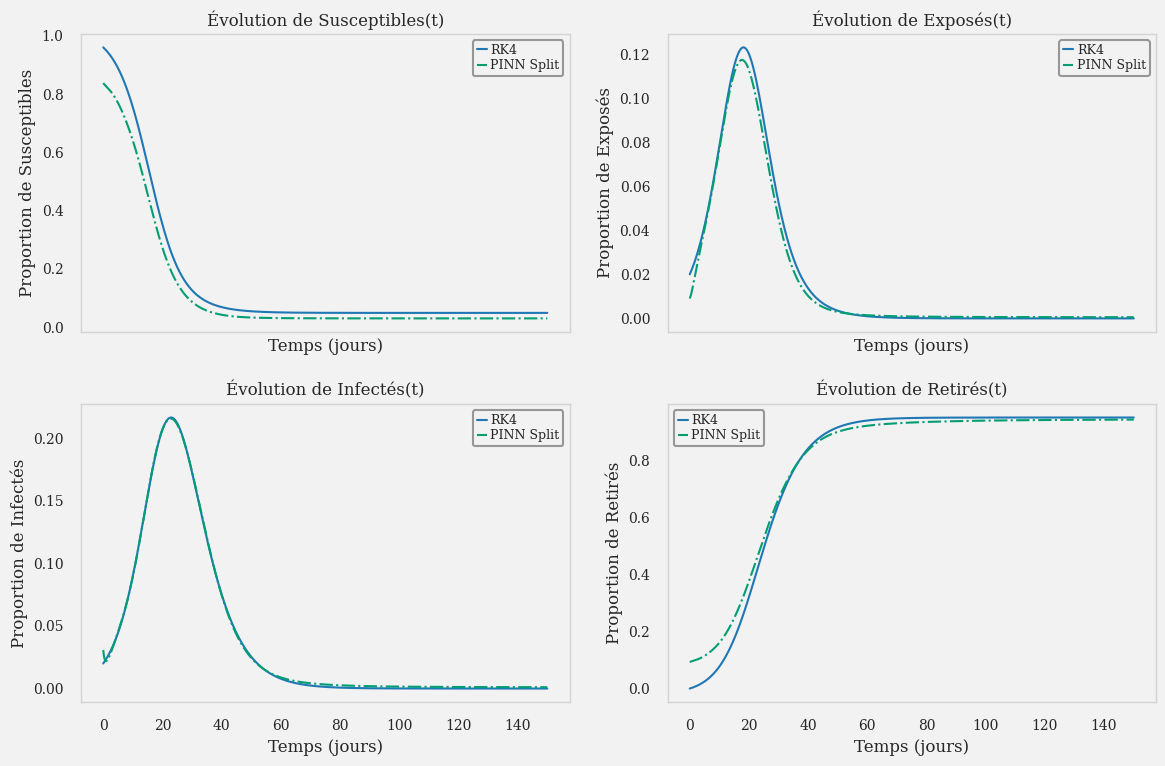

In [ ]:
# --------------------------------------------
# BLOC 3B : Figure RK4 vs PINN Split
# --------------------------------------------
fig, axs = plt.subplots(2,2,figsize=(12,8), sharex=True)
split_vals = [S_B, E_B, I_B, R_B]

for ax, lab, rk4, sp in zip(axs.ravel(), labels, rk4_vals, split_vals):
    ax.plot(t_list, rk4,
            color="#1f77b4", linestyle="-", linewidth=1.5, label="RK4")
    ax.plot(t_list, sp,
            color="C2", linestyle="-.", linewidth=1.5, label="PINN Split")
    ax.set_title(f"Évolution de {lab}(t)", pad=6)
    ax.set_xlabel("Temps (jours)")
    ax.set_ylabel(f"Proportion de {lab}")
    ax.set_facecolor("#f2f2f2")
    ax.grid(False)
    leg = ax.legend(loc="best", frameon=True,
                    fontsize=9, handlelength=0.8,
                    handletextpad=0.3, borderpad=0.3,
                    labelspacing=0.2)
    leg.get_frame().set_facecolor("none")
    leg.get_frame().set_edgecolor("gray")


plt.tight_layout()
# ✅ Sauvegarde de la figure
plt.savefig("comparaison_SEIR_PINN_vs_RK4_splita.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

In [ ]:
from google.colab import files
files.download("comparaison_SEIR_PINN_vs_RK4_splita.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

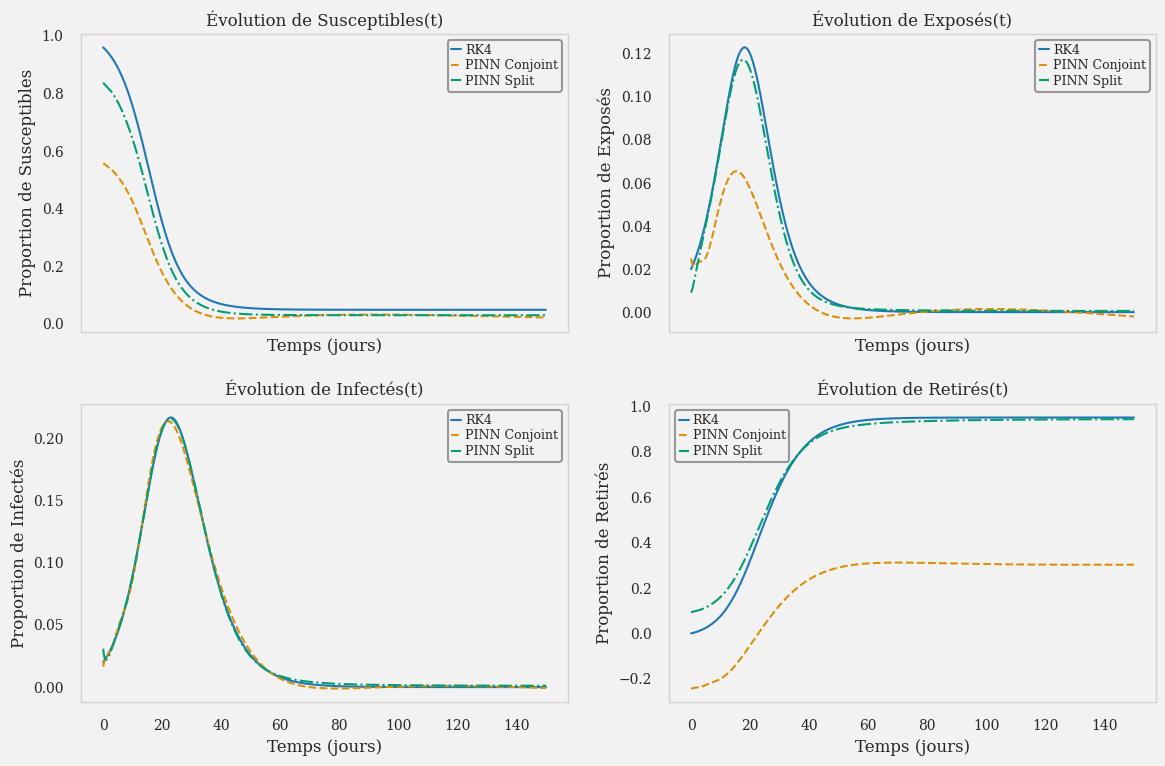

In [ ]:
# --------------------------------------------
# BLOC 2 : Extraction des courbes simulées
# (Suppose que t_list, S_list, E_list, I_list, R_list
#  et t_tf, modelC, modelB, modelA sont déjà définis)
# --------------------------------------------

# RK4 (vérités simulées)
rk4_vals  = [S_list, E_list, I_list, R_list]

# Conjoint : prédictions 4 sorties
outsC = modelC(t_tf)
S_C, E_C, I_C, R_C = [x.numpy().squeeze() for x in tf.split(outsC, 4, axis=1)]
conj_vals = [S_C, E_C, I_C, R_C]

# Split : S, E, R du modelB + I du modelA
outsB = modelB(t_tf)
S_B, E_B, R_B = [x.numpy().squeeze() for x in tf.split(outsB, 3, axis=1)]
I_B = modelA(t_tf).numpy().squeeze()
split_vals = [S_B, E_B, I_B, R_B]

# --------------------------------------------
# BLOC 3 : Tracé comparatif 2×2
# --------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

labels = ["Susceptibles", "Exposés", "Infectés", "Retirés"]

for ax, lab, rk4, cj, sp in zip(axs.ravel(), labels, rk4_vals, conj_vals, split_vals):
    # RK4 : bleu
    ax.plot(t_list, rk4, color="#1f77b4", linestyle="-", linewidth=1.5, label="RK4")
    # Conjoint : orange pointillé
    ax.plot(t_list, cj, color="C1", linestyle="--", linewidth=1.5, label="PINN Conjoint")
    # Split : vert tireté
    ax.plot(t_list, sp, color="C2", linestyle="-.", linewidth=1.5, label="PINN Split")

    ax.set_title(f"Évolution de {lab}(t)", pad=6)
    ax.set_xlabel("Temps (jours)")
    ax.set_ylabel(f"Proportion de {lab}")
    ax.set_facecolor("#f2f2f2")
    ax.grid(False)

    leg = ax.legend(loc="best", frameon=True,
                    fontsize=9, handlelength=0.8,
                    handletextpad=0.3, borderpad=0.3,
                    labelspacing=0.2)
    leg.get_frame().set_facecolor("none")
    leg.get_frame().set_edgecolor("gray")


plt.tight_layout()
# ✅ Sauvegarde de la figure
plt.savefig("comparaison_SEIR_PINN_vs_RK4_deux.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

In [ ]:
from google.colab import files
files.download("comparaison_SEIR_PINN_vs_RK4_deux.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ─────────────────────────────────────────────────────────────
# Bloc 4 ter – Tableau des écarts RK4 vs PINNs (Split + Conjoint)
# ─────────────────────────────────────────────────────────────
# 1) Prédictions Conjoint-PINN (sorties : S, E, I, R)
outsC = modelC(t_tf)
S_C, E_C, I_C, R_C = (x.numpy().squeeze() for x in tf.split(outsC, 4, axis=1))

# 2) Prédictions Split-PINN (sorties : S, E, R)
outsB = modelB(t_tf)
S_B, E_B, R_B = (x.numpy().squeeze() for x in tf.split(outsB, 3, axis=1))
I_B = modelA(t_tf).numpy().squeeze()  # I(t) séparé

# 3) Construire le DataFrame général (RK4, Conjoint, Split)
df_table = pd.DataFrame({
    "Temps":       df["Temps"].values,
    # RK4 (vérité terrain)
    "S_RK4":       df["S"].values,
    "E_RK4":       df["E"].values,
    "I_RK4":       df["I"].values,
    "R_RK4":       df["R"].values,
    # Conjoint-PINN
    "S_Conjoint":  S_C,
    "E_Conjoint":  E_C,
    "I_Conjoint":  I_C,
    "R_Conjoint":  R_C,
    # Split-PINN
    "S_Split":     S_B,
    "E_Split":     E_B,
    "I_Split":     I_B,
    "R_Split":     R_B,
})

# 4) Calcul des écarts (PINN - RK4) pour chaque méthode
for comp in ["S", "E", "I", "R"]:
    df_table[f"{comp}_Δ_Conjoint"] = df_table[f"{comp}_Conjoint"] - df_table[f"{comp}_RK4"]
    df_table[f"{comp}_Δ_Split"]    = df_table[f"{comp}_Split"]    - df_table[f"{comp}_RK4"]

# 5) Extraction des colonnes à afficher (10 premières lignes arrondies)
diff_cols = (
    ["Temps"]
  + [f"{c}_Δ_Conjoint" for c in ["S", "E", "I", "R"]]
  + [f"{c}_Δ_Split"    for c in ["S", "E", "I", "R"]]
)
df_to_show = df_table[diff_cols].head(10).round(4)

# 6) Affichage dans le notebook
display(df_to_show)


,Temps,S_Δ_Conjoint,E_Δ_Conjoint,I_Δ_Conjoint,R_Δ_Conjoint,S_Δ_Split,E_Δ_Split,I_Δ_Split,R_Δ_Split
0,0.0,-0.4025,0.0049,-0.0035,-0.2424,-0.1225,-0.0110,0.0108,0.0932
1,0.1,-0.4017,0.0039,-0.0027,-0.2428,-0.1228,-0.0109,0.0081,0.0932
2,0.2,-0.4011,0.0030,-0.0019,-0.2431,-0.1231,-0.0109,0.0059,0.0932
3,0.3,-0.4006,0.0021,-0.0013,-0.2433,-0.1233,-0.0107,0.0042,0.0932
4,0.4,-0.4003,0.0013,-0.0008,-0.2434,-0.1234,-0.0106,0.0028,0.0932
5,0.5,-0.3999,0.0006,-0.0003,-0.2435,-0.1235,-0.0104,0.0016,0.0931
6,0.6,-0.3997,-0.0001,0.0000,-0.2434,-0.1236,-0.0102,0.0006,0.0931
7,0.7,-0.3994,-0.0007,0.0003,-0.2434,-0.1236,-0.0099,-0.0001,0.0931
8,0.8,-0.3992,-0.0012,0.0004,-0.2434,-0.1235,-0.0096,-0.0008,0.0931
9,0.9,-0.3989,-0.0016,0.0005,-0.2434,-0.1235,-0.0094,-0.0013,0.0931


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score

# ─── 1) Données vérités issues de RK4 ─────────────────────
true = {
    "S": df["S"].values,
    "E": df["E"].values,
    "I": df["I"].values,
    "R": df["R"].values,
}

# ─── 2) Prédictions du modèle Conjoint-PINN ──────────────
outsC = modelC(t_tf)
S_conj, E_conj, I_conj, R_conj = (
    x.numpy().squeeze() for x in tf.split(outsC, 4, axis=1)
)
pred_conj = {"S": S_conj, "E": E_conj, "I": I_conj, "R": R_conj}

# ─── 3) Prédictions du modèle Split-PINN ─────────────────
outsB = modelB(t_tf)
S_split, E_split, R_split = (
    x.numpy().squeeze() for x in tf.split(outsB, 3, axis=1)
)
I_split = modelA(t_tf).numpy().squeeze()
pred_split = {"S": S_split, "E": E_split, "I": I_split, "R": R_split}

# ─── 4) Calcul des métriques par compartiment ────────────
rows = []
for comp in ["S", "E", "I", "R"]:
    y = true[comp]
    for name, pred in [
        ("Conjoint-PINN", pred_conj[comp]),
        ("Split-PINN",    pred_split[comp])
    ]:
        mse  = np.mean((pred - y)**2)
        rmse = np.sqrt(mse)
        mae  = mean_absolute_error(y, pred)
        r2   = r2_score(y, pred)
        rows.append({
            "Compartiment": comp,
            "Méthode":      name,
            "MSE":          mse,
            "RMSE":         rmse,
            "MAE":          mae,
            "R² (%)":       r2 * 100
        })

df_metrics = pd.DataFrame(rows)

# ─── 5) Affichage formaté clair ──────────────────────────
formatters = {
    "MSE":     "{:.3e}".format,
    "RMSE":    "{:.3e}".format,
    "MAE":     "{:.3e}".format,
    "R² (%)":  "{:.2f}%".format,
}

print(df_metrics.to_string(index=False, formatters=formatters))


Compartiment       Méthode       MSE      RMSE       MAE   R² (%)
           S Conjoint-PINN 1.555e-02 1.247e-01 7.054e-02   72.11%
           S    Split-PINN 2.198e-03 4.689e-02 3.483e-02   96.06%
           E Conjoint-PINN 3.748e-04 1.936e-02 1.007e-02   69.51%
           E    Split-PINN 9.461e-06 3.076e-03 1.875e-03   99.23%
           I Conjoint-PINN 6.416e-06 2.533e-03 1.828e-03   99.85%
           I    Split-PINN 1.725e-06 1.313e-03 1.163e-03   99.96%
           R Conjoint-PINN 3.471e-01 5.892e-01 5.757e-01 -294.84%
           R    Split-PINN 1.094e-03 3.308e-02 2.225e-02   98.76%


## VI. Données réelles – COVID Maroc


***Vague Delta_Covid***

In [ ]:
url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
df = pd.read_csv(url, parse_dates=["date"], usecols=["iso_code", "date", "new_cases"])
df = df[df.iso_code == "MAR"].sort_values("date").reset_index(drop=True)
#────────────────────────Extraction de la vague Delta (01/07/21 → 01/11/21)────────────────────────
df = df[(df.date >= "2021-07-01") & (df.date <= "2021-11-01")].reset_index(drop=True)

In [ ]:
# @title Titre par défaut
n = len(df)

# 10 premières lignes
print("🔹 10 premières lignes :")
print(df.head(10))

# 10 lignes au milieu
print("\n🔹 10 lignes centrales :")
mid_start = n // 2 - 5
print(df.iloc[mid_start:mid_start + 10])

# 10 dernières lignes
print("\n🔹 10 dernières lignes :")
print(df.tail(10))

🔹 10 premières lignes :
  iso_code       date  new_cases  jour    t_norm  I_active        C   I_frac
0      MAR 2021-07-01          0     0  0.000000       0.0  0.00000  0.00000
1      MAR 2021-07-02          0     1  0.008130       0.0  0.00000  0.00000
2      MAR 2021-07-03          0     2  0.016260       0.0  0.00000  0.00000
3      MAR 2021-07-04       4721     3  0.024390    4721.0  0.00944  0.00944
4      MAR 2021-07-05          0     4  0.032520    4721.0  0.00000  0.00944
5      MAR 2021-07-06          0     5  0.040650    4721.0  0.00000  0.00944
6      MAR 2021-07-07          0     6  0.048780    4721.0  0.00000  0.00944
7      MAR 2021-07-08          0     7  0.056911    4721.0  0.00000  0.00944
8      MAR 2021-07-09          0     8  0.065041    4721.0  0.00000  0.00944
9      MAR 2021-07-10          0     9  0.073171    4721.0  0.00000  0.00944

🔹 10 lignes centrales :
   iso_code       date  new_cases  jour    t_norm  I_active         C  \
57      MAR 2021-08-27         

In [ ]:
df.new_cases = pd.to_numeric(df.new_cases, errors="coerce").fillna(0).astype(int)
df["jour"]   = (df.date - df.date.iloc[0]).dt.days.astype(int)
df["t_norm"] = df.jour / df.jour.max()

In [ ]:
# ─── 2. Incidence & prévalence active ────────────────────────
D = 7 # Cela représente le nombre de jours pendant lesquels une personne infectée est considérée comme "contagieuse"
df["I_active"] = df.new_cases.rolling(D, min_periods=1).sum()#Cette méthode crée une fenêtre glissante de taille D,
                                                             #elle calcule la somme des cas des 7 jours précédents.

CUM_WAVE = float(df.new_cases.sum())                   # le nombre total de cas détectés sur toute la période de la vague
rho      = 1.2                                         # facteur sous‑détection,en général
                                                        #tous les cas ne sont pas détectés (tests limités, asymptomatiques non testés, etc.)
                                                        #On estime que seulement 1/1.2 (environ 83%) des cas sont détectés
N_eff    = CUM_WAVE * rho                              # population effectivement exposée

df["C"]      = df.new_cases  / N_eff  #taux d'incidence normalisé,
                                      #Cela donne une fraction (entre 0 et 1) représentant la proportion par rapport à la population touchée
df["I_frac"] = df.I_active   / N_eff #taux de prévalence active normalisé(la fraction de la population qui est actuellement infectée.

print("Contrôle avant entraînement:")
print("  max(I_frac) ≈", df.I_frac.max())# le pic d'infection pendant la vague.
print("  S0 ≈", 1 - df.I_frac.iloc[0] - 0.5*df.I_frac.iloc[0])  # On estime S0 en retirant de la population totale les infectés visibles (I_frac(0))
                                                                # ainsi que 50% supplémentaires pour représenter ceux qui sont en incubation,
                                                                # donnant une approximation réaliste de la population encore non touchée au jour 0.


Contrôle avant entraînement:
  max(I_frac) ≈ 0.1295464434718063
  S0 ≈ 1.0


In [ ]:
# ─── Séparation Train/Test ───────────────────────────────
n         = len(df)
idx_split = int(0.8 * n)

# Train
t_train   = df.t_norm.values[:idx_split].reshape(-1,1).astype("float32")
C_train   = df.C.values[:idx_split].reshape(-1,1).astype("float32")
I_train   = df.I_frac.values[:idx_split].reshape(-1,1).astype("float32")

# Test
t_test    = df.t_norm.values[idx_split:].reshape(-1,1).astype("float32")
C_test    = df.C.values[idx_split:].reshape(-1,1).astype("float32")
I_test    = df.I_frac.values[idx_split:].reshape(-1,1).astype("float32")

t_scale   = tf.constant(df.jour.max(), dtype=tf.float32)

In [ ]:
# ─── 3. Modèle Split‑PINN ────────────────────────────────────
def build_subnet(out_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(40, activation="tanh"),
        tf.keras.layers.Dense(40, activation="swish"),
        tf.keras.layers.Dense(30, activation="swish"),
        tf.keras.layers.Dense(out_dim)
    ])
class SplitPINN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.log_K  = tf.Variable(0.0, dtype=tf.float32, trainable=True)
        self.nn_I   = build_subnet(1)
        self.nn_SER = build_subnet(3)
        self.log_b  = tf.Variable(np.float32(np.log(0.8)),  trainable=True)
        self.log_s  = tf.Variable(np.float32(np.log(0.3)),  trainable=True)
        self.log_g  = tf.Variable(np.float32(np.log(0.15)),  trainable=True)

    def call(self, t):
        K = tf.sigmoid(self.log_K)
        Ih = tf.keras.activations.sigmoid(self.nn_I(t))
        xyz = tf.nn.softmax(self.nn_SER(t), axis=1)
        S, E, R = tf.split(xyz * (1. - tf.broadcast_to(Ih, tf.shape(xyz))), 3, axis=1)
        β, σ, γ = tf.exp(self.log_b), tf.exp(self.log_s), tf.exp(self.log_g)
        return K, Ih, S, E, R, β, σ, γ
# Remarque : Dans ce notebook, le paramètre γ (gamma) est utilisé pour représenter λ (lambda)
# dans le modèle SEIR. Ainsi, lorsque nous faisons référence à γ, cela correspond en fait à λ dans ce contexte spécifique.


### VI.1. Application aux données réelles – Entraînement Split-PINN


In [ ]:
model = SplitPINN()
mse   = tf.keras.losses.MeanSquaredError()

In [ ]:
# ─── 4. Phase A : estimation de k ────────────────────────────
optA = tf.keras.optimizers.Nadam(1e-3)
@tf.function
def stepA(t,C):
    with tf.GradientTape() as g:
        K,Ih,*_ = model(t)
        L = mse(C, K*Ih)
    optA.apply_gradients([(g.gradient(L, model.log_K), model.log_K)])
    return L
for ep in range(4000):
    la = stepA(t_train, C_train)
    if ep%500==0:
        print(f"[A] {ep:4d}  L={la:.2e}  k={tf.sigmoid(model.log_K):.3f}")

[A]    0  L=6.06e-02  k=0.500
[A]  500  L=3.58e-02  k=0.386
[A] 1000  L=2.12e-02  k=0.300
[A] 1500  L=1.32e-02  k=0.237
[A] 2000  L=8.59e-03  k=0.192
[A] 2500  L=5.88e-03  k=0.159
[A] 3000  L=4.19e-03  k=0.134
[A] 3500  L=3.10e-03  k=0.114


In [ ]:
# ─── 5. Phase B : ajustement Î(t) ───────────────────────────
optB = tf.keras.optimizers.Nadam(1e-3)
@tf.function
def stepB(t,Iobs):
    with tf.GradientTape() as g:
        _,Ih,*_ = model(t)
        L = mse(Iobs, Ih)
    optB.apply_gradients(zip(g.gradient(L, model.nn_I.trainable_variables),
                             model.nn_I.trainable_variables))
    return L
for ep in range(4000):
    lb = stepB(t_train, I_train)
    if ep%500==0:
        print(f"[B] {ep:4d}  L={lb:.2e}")

[B]    0  L=2.03e-01
[B]  500  L=2.03e-03
[B] 1000  L=1.81e-03
[B] 1500  L=1.51e-03
[B] 2000  L=8.04e-05
[B] 2500  L=6.82e-05
[B] 3000  L=6.71e-05
[B] 3500  L=6.59e-05


In [ ]:
# ─── 6. Phase C : calibration complète sans pondération ───────────────
optC = tf.keras.optimizers.Nadam(1e-4)

I0 = float(I_train[0])
E0 = 0.02
R0 = 0.0
S0 = 1.0 - I0 - E0 - R0

@tf.function
def stepC(t, Iobs):
    with tf.GradientTape(persistent=True) as g:
        K, Ih, S, E, R, β, σ, γ = model(t)
        g.watch(t)
        dS, dE, dI, dR = [g.gradient(x, t) / t_scale for x in (S, E, Ih, R)]

        # Composantes de la perte
        L_I  = mse(Iobs, Ih)
        L_ic = (S[0, 0] - S0)**2 + (E[0, 0] - E0)**2 + (Ih[0, 0] - I0)**2 + (R[0, 0] - R0)**2
        resS = dS + β * S * Ih
        resE = dE - β * S * Ih + σ * E
        resI = dI - σ * E + γ * Ih
        resR = dR - γ * Ih
        L_ODE = tf.reduce_mean(resS**2 + resE**2 + resI**2 + resR**2)
        L_sum = tf.reduce_mean((S + E + Ih + R - 1.0)**2)

        # Total loss sans pondération
        Ltot = L_I + L_ic + L_ODE + L_sum

    varsC = model.nn_SER.trainable_variables + [model.log_b, model.log_s, model.log_g]
    optC.apply_gradients(zip(g.gradient(Ltot, varsC), varsC))
    return Ltot, β, σ, γ

for ep in range(8000):
    Lc, beta, sigma, gamma = stepC(t_train, I_train)
    if ep % 500 == 0:
        print(f"[C] {ep:4d}  L={Lc:.2e}  β={beta:.3f}  σ={sigma:.3f}  γ={gamma:.3f}")
# Remarque : Dans ce notebook, le paramètre γ (gamma) est utilisé pour représenter λ (lambda)
# dans le modèle SEIR. Ainsi, lorsque nous faisons référence à γ, cela correspond en fait à λ dans ce contexte spécifique.


<ipython-input-215-4151100472>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  I0 = float(I_train[0])


[C]    0  L=6.42e-01  β=0.800  σ=0.300  γ=0.150
[C]  500  L=1.61e-02  β=0.772  σ=0.294  γ=0.153
[C] 1000  L=4.09e-03  β=0.724  σ=0.294  γ=0.148
[C] 1500  L=3.12e-03  β=0.692  σ=0.294  γ=0.145
[C] 2000  L=2.82e-03  β=0.662  σ=0.293  γ=0.141
[C] 2500  L=2.59e-03  β=0.634  σ=0.291  γ=0.137
[C] 3000  L=2.38e-03  β=0.608  σ=0.290  γ=0.132
[C] 3500  L=2.18e-03  β=0.583  σ=0.288  γ=0.128
[C] 4000  L=1.98e-03  β=0.559  σ=0.285  γ=0.123
[C] 4500  L=1.79e-03  β=0.537  σ=0.282  γ=0.119
[C] 5000  L=1.52e-03  β=0.516  σ=0.278  γ=0.116
[C] 5500  L=4.91e-04  β=0.503  σ=0.271  γ=0.119
[C] 6000  L=1.89e-04  β=0.500  σ=0.268  γ=0.126
[C] 6500  L=1.58e-04  β=0.499  σ=0.266  γ=0.132
[C] 7000  L=1.44e-04  β=0.498  σ=0.265  γ=0.137
[C] 7500  L=1.35e-04  β=0.497  σ=0.263  γ=0.143


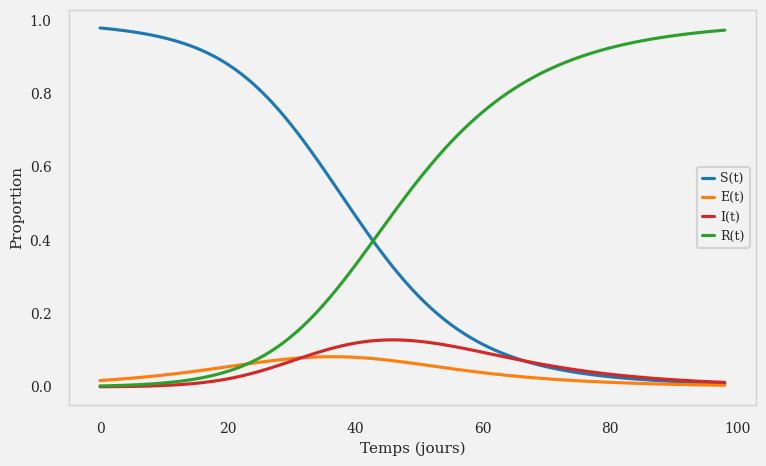

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ─── 7. Visualisation SEIR sans grille, style cohérent ───────────────
# Style graphique harmonisé
sns.set_theme(style="white", context="talk", palette="colorblind")
plt.rcParams["figure.facecolor"] = "#f2f2f2"
plt.rcParams["axes.facecolor"]   = "#f2f2f2"
plt.rcParams["axes.edgecolor"]   = "lightgray"
plt.rcParams["axes.linewidth"]   = 1.0
plt.rc("font",   family="serif", weight="light")
plt.rc("axes",   titlesize=13, labelsize=11)
plt.rc("legend", fontsize=9, handlelength=1, handletextpad=0.5, borderpad=0.4)
plt.rc("xtick",  labelsize=10)
plt.rc("ytick",  labelsize=10)

# Données
K, Ih, S, E, R, β, σ, γ = model(t_train)
# Remarque : Dans ce notebook, le paramètre γ (gamma) est utilisé pour représenter λ (lambda)
# dans le modèle SEIR. Ainsi, lorsque nous faisons référence à γ, cela correspond en fait à λ dans ce contexte spécifique.

# Création de la figure
fig = plt.figure(figsize=(8,5))  # ✅ définition de fig
plt.plot(df.jour[:idx_split], S.numpy().squeeze(), label="S(t)", color="tab:blue")
plt.plot(df.jour[:idx_split], E.numpy().squeeze(), label="E(t)", color="tab:orange")
plt.plot(df.jour[:idx_split], Ih.numpy().squeeze(), label="I(t)", color="tab:red")
plt.plot(df.jour[:idx_split], R.numpy().squeeze(), label="R(t)", color="tab:green")

# Axes et légende
plt.xlabel("Temps (jours)")
plt.ylabel("Proportion")
plt.legend()
plt.tight_layout()

# ✅ Sauvegarde sans erreur
plt.savefig("SEIR_Maroc.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

# 📥 Téléchargement dans Google Colab
from google.colab import files
files.download("SEIR_Maroc.pdf")


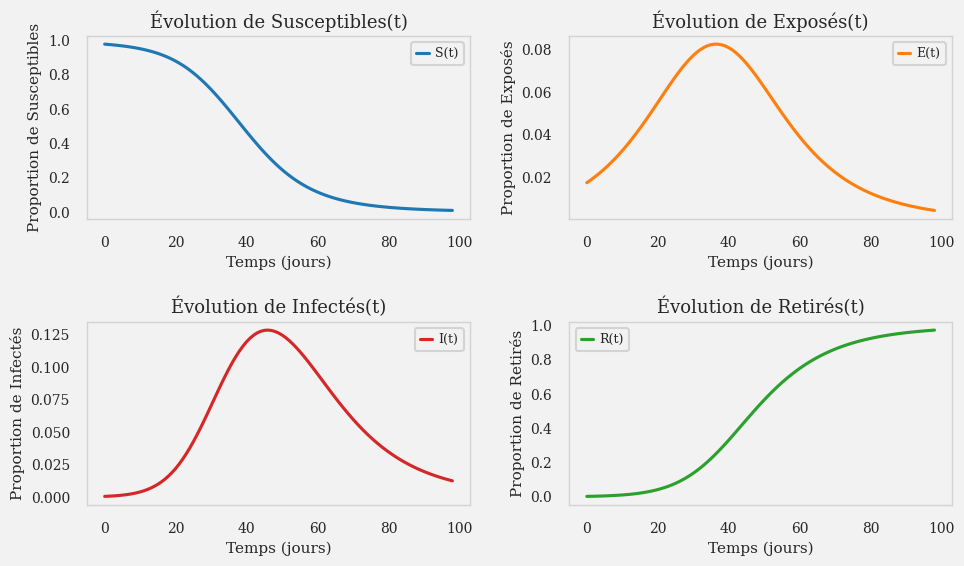

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ─── Visualisation SEIR – 4 sous-graphes avec style harmonisé ─────────────────────
from google.colab import files

# 🎨 Style graphique uniforme
sns.set_theme(style="white", context="talk", palette="colorblind")
plt.rcParams["figure.facecolor"] = "#f2f2f2"
plt.rcParams["axes.facecolor"]   = "#f2f2f2"
plt.rcParams["axes.edgecolor"]   = "lightgray"
plt.rcParams["axes.linewidth"]   = 1.0
plt.rc("font",   family="serif", weight="light")
plt.rc("axes",   titlesize=13, labelsize=11)
plt.rc("legend", fontsize=9, handlelength=1, handletextpad=0.5, borderpad=0.4)
plt.rc("xtick",  labelsize=10)
plt.rc("ytick",  labelsize=10)

# 🔢 Données depuis le modèle
K, Ih, S, E, R, β, σ, γ = model(t_train) # Remarque : Dans ce notebook, le paramètre γ (gamma) est utilisé pour représenter λ (lambda)
# dans le modèle SEIR. Ainsi, lorsque nous faisons référence à γ, cela correspond en fait à λ dans ce contexte spécifique.
jours_train = df.jour[:idx_split]

# 📊 Figure 2x2
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Sous-graphe S(t)
axs[0, 0].plot(jours_train, S.numpy().squeeze(), color="tab:blue", label="S(t)")
axs[0, 0].set_title("Évolution de Susceptibles(t)")
axs[0, 0].set_xlabel("Temps (jours)")
axs[0, 0].set_ylabel("Proportion de Susceptibles")
axs[0, 0].legend()

# Sous-graphe E(t)
axs[0, 1].plot(jours_train, E.numpy().squeeze(), color="tab:orange", label="E(t)")
axs[0, 1].set_title("Évolution de Exposés(t)")
axs[0, 1].set_xlabel("Temps (jours)")
axs[0, 1].set_ylabel("Proportion de Exposés")
axs[0, 1].legend()

# Sous-graphe I(t)
axs[1, 0].plot(jours_train, Ih.numpy().squeeze(), color="tab:red", label="I(t)")
axs[1, 0].set_title("Évolution de Infectés(t)")
axs[1, 0].set_xlabel("Temps (jours)")
axs[1, 0].set_ylabel("Proportion de Infectés")
axs[1, 0].legend()

# Sous-graphe R(t)
axs[1, 1].plot(jours_train, R.numpy().squeeze(), color="tab:green", label="R(t)")
axs[1, 1].set_title("Évolution de Retirés(t)")
axs[1, 1].set_xlabel("Temps (jours)")
axs[1, 1].set_ylabel("Proportion de Retirés")
axs[1, 1].legend()

# ✅ Sauvegarde
plt.tight_layout()
plt.savefig("SEIR_Maroc_4plots.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

# 📥 Téléchargement dans Google Colab
files.download("SEIR_Maroc_4plots.pdf")


In [ ]:
# 🔄 Prédiction des compartiments SEIR pour les données de train
K, Ih, S, E, R, β, σ, γ = model(t_train)
# Remarque : Dans ce notebook, le paramètre γ (gamma) est utilisé pour représenter λ (lambda)
# dans le modèle SEIR. Ainsi, lorsque nous faisons référence à γ, cela correspond en fait à λ dans ce contexte spécifique.

data = {
    "Jour": df.jour[:idx_split],
    "S(t)": S.numpy().squeeze(),
    "E(t)": E.numpy().squeeze(),
    "I(t)": Ih.numpy().squeeze(),
    "R(t)": R.numpy().squeeze()
}
df_seir_train = pd.DataFrame(data)
print("\n📊 Tableau des valeurs finales SEIR (Vague Delta - Entraînement)")
print(df_seir_train.tail(10).to_string(index=False))


📊 Tableau des valeurs finales SEIR (Vague Delta - Entraînement)
 Jour     S(t)     E(t)     I(t)     R(t)
   89 0.015951 0.007544 0.020824 0.955680
   90 0.015050 0.007131 0.019670 0.958149
   91 0.014210 0.006741 0.018581 0.960468
   92 0.013424 0.006374 0.017554 0.962648
   93 0.012691 0.006027 0.016585 0.964697
   94 0.012004 0.005700 0.015672 0.966623
   95 0.011362 0.005392 0.014810 0.968435
   96 0.010761 0.005102 0.013998 0.970140
   97 0.010197 0.004827 0.013232 0.971744
   98 0.009668 0.004568 0.012511 0.973253


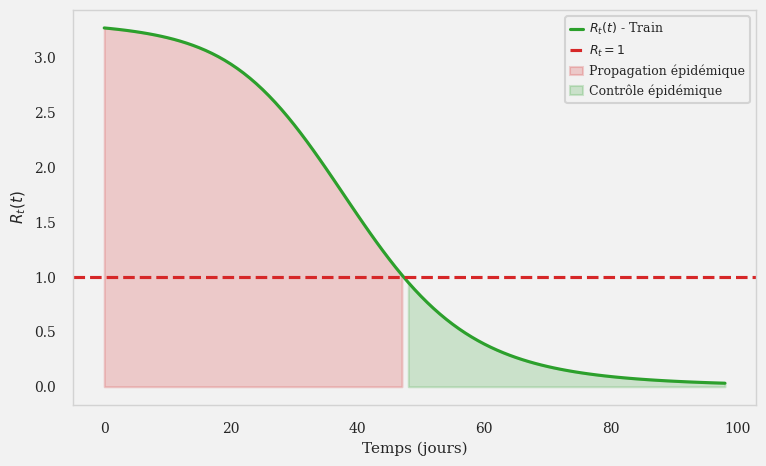

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 🔄 Visualisation de Rₜ(t) effectif – style cohérent
_, _, S_train, _, _, beta_v, _, gamma_v = model(t_train)
R0_t_train = (beta_v / gamma_v) * S_train.numpy().squeeze()
jours_train = df.jour[:idx_split]

# 📊 Tracé
fig = plt.figure(figsize=(8, 5))
plt.plot(jours_train, R0_t_train, color="tab:green", label="$R_t(t)$ - Train")
plt.axhline(1, color="tab:red", linestyle="--", label="$R_t = 1$")
plt.fill_between(jours_train, 0, R0_t_train, where=(R0_t_train > 1),
                 color="tab:red", alpha=0.2, label="Propagation épidémique")
plt.fill_between(jours_train, 0, R0_t_train, where=(R0_t_train <= 1),
                 color="tab:green", alpha=0.2, label="Contrôle épidémique")

plt.xlabel("Temps (jours)")
plt.ylabel("$R_t(t)$")
plt.legend()
plt.tight_layout()

# ✅ Sauvegarde PDF
plt.savefig("Rt_Train.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

# 📥 Téléchargement
from google.colab import files
files.download("Rt_Train.pdf")


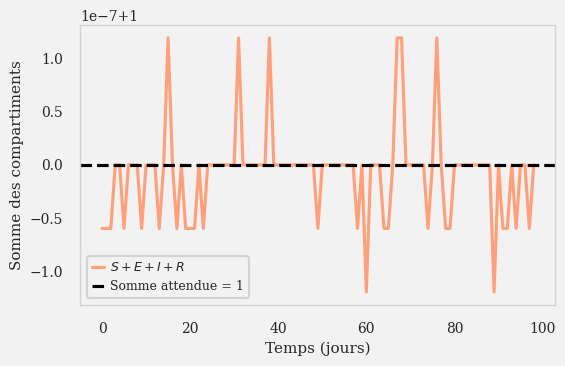

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 🔄 Vérification conservation S+E+I+R (Train) – style cohérent avec courbe orange clair

# Données
# Remarque : Dans ce notebook, le paramètre γ (gamma) est utilisé pour représenter λ (lambda)
# dans le modèle SEIR. Ainsi, lorsque nous faisons référence à γ, cela correspond en fait à λ dans ce contexte spécifique.

K_train, Ih_train, S_train, E_train, R_train, β_train, σ_train, γ_train = model(t_train)
SERI_sum = (S_train + E_train + Ih_train + R_train).numpy().squeeze()
# Remarque : Dans ce notebook, le paramètre γ (gamma) est utilisé pour représenter λ (lambda)
# dans le modèle SEIR. Ainsi, lorsque nous faisons référence à γ, cela correspond en fait à λ dans ce contexte spécifique.

# Tracé
fig = plt.figure(figsize=(6, 4))
plt.plot(df.jour[:idx_split], SERI_sum, label="$S + E + I + R$", color="lightsalmon")
plt.axhline(1.0, color="black", linestyle="--", label="Somme attendue = 1")

plt.xlabel("Temps (jours)")
plt.ylabel("Somme des compartiments")
plt.legend()
plt.tight_layout()

# Sauvegarde PDF
plt.savefig("SEIR_conservation_lightsalmon.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

# Téléchargement
from google.colab import files
files.download("SEIR_conservation_lightsalmon.pdf")


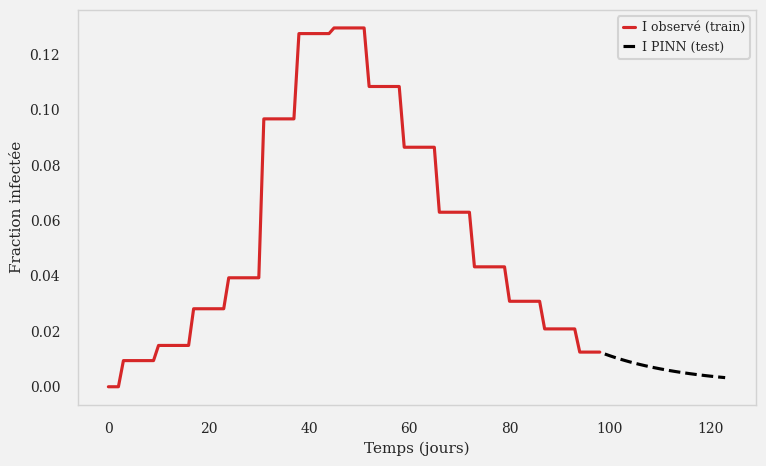

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📊 Tableau de comparaison (Test) :

 Jour  I Réel (Test)  I Prédit (PINN)  Erreur Absolue
   99       0.012512         0.011830        0.000682
  100       0.012512         0.011189        0.001323
  101       0.007945         0.010584        0.002639
  102       0.007945         0.010014        0.002069
  103       0.007945         0.009476        0.001531
  104       0.007945         0.008969        0.001024
  105       0.007945         0.008491        0.000546
  106       0.007945         0.008040        0.000095
  107       0.007945         0.007615        0.000330
  108       0.006123         0.007213        0.001090


In [ ]:
# 📈 Visualisation I(t) – Entraînement vs Test (style harmonisé)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error
from google.colab import files

# 🔧 Style graphique harmonisé
sns.set_theme(style="white", context="talk", palette="colorblind")
plt.rcParams["figure.facecolor"] = "#f2f2f2"
plt.rcParams["axes.facecolor"]   = "#f2f2f2"
plt.rcParams["axes.edgecolor"]   = "lightgray"
plt.rcParams["axes.linewidth"]   = 1.0
plt.rc("font",   family="serif", weight="light")
plt.rc("axes",   titlesize=13, labelsize=11)
plt.rc("legend", fontsize=9, handlelength=1, handletextpad=0.5, borderpad=0.4)
plt.rc("xtick",  labelsize=10)
plt.rc("ytick",  labelsize=10)

# 🔎 Prédiction sur Test
K_test, Ih_test, *_ = model(t_test)
jours      = df.jour.values
jours_test = jours[idx_split:]
mse_test   = mean_squared_error(I_test.squeeze(), Ih_test.numpy().squeeze())

# 📊 Tracé
fig = plt.figure(figsize=(8,5))
plt.plot(jours[:idx_split], I_train.squeeze(), label="I observé (train)", color="tab:red")
plt.plot(jours_test, Ih_test.numpy().squeeze(), linestyle="--", label="I PINN (test)", color="black")

plt.xlabel("Temps (jours)")
plt.ylabel("Fraction infectée")
plt.legend()
plt.tight_layout()

# ✅ Sauvegarde PDF
plt.savefig("I_test_prediction.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()
files.download("I_test_prediction.pdf")

# 📄 Création du tableau de comparaison
df_comparaison = pd.DataFrame({
    "Jour": jours_test,
    "I Réel (Test)": I_test.squeeze(),
    "I Prédit (PINN)": Ih_test.numpy().squeeze(),
    "Erreur Absolue": abs(I_test.squeeze() - Ih_test.numpy().squeeze())
})

print("\n📊 Tableau de comparaison (Test) :\n")
print(df_comparaison.head(10).to_string(index=False))


In [ ]:
# ───  Métriques de validation sur le jeu Test ───────────────────────────
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 🔄 Réel vs. prédit sur la zone Test
I_real = I_test.squeeze()
I_pred = Ih_test.numpy().squeeze()
#  Calcul des métriques
mae  = mean_absolute_error(I_real, I_pred)
mse  = mean_squared_error(I_real, I_pred)
rmse = np.sqrt(mse)
r2   = r2_score(I_real, I_pred)
print("\n📊  Validation du modèle (jeu Test)")
print(f"   MAE   = {mae:.4e}")
print(f"   MSE   = {mse:.4e}")
print(f"   RMSE  = {rmse:.4e}")
print(f"   R²    = {r2:.4f}")



📊  Validation du modèle (jeu Test)
   MAE   = 7.1217e-04
   MSE   = 8.8693e-07
   RMSE  = 9.4177e-04
   R²    = 0.8332


In [ ]:
print(f"\n✅ Paramètres estimés :")
print(f"β     = {beta:.4f}")
print(f"σ     = {sigma:.4f}")
print(f"γ     = {gamma:.4f}")
# Remarque : Dans ce notebook, le paramètre γ (gamma) est utilisé pour représenter λ (lambda)
# dans le modèle SEIR. Ainsi, lorsque nous faisons référence à γ, cela correspond en fait à λ dans ce contexte spécifique.



✅ Paramètres estimés :
β     = 0.4899
σ     = 0.2621
γ     = 0.1448


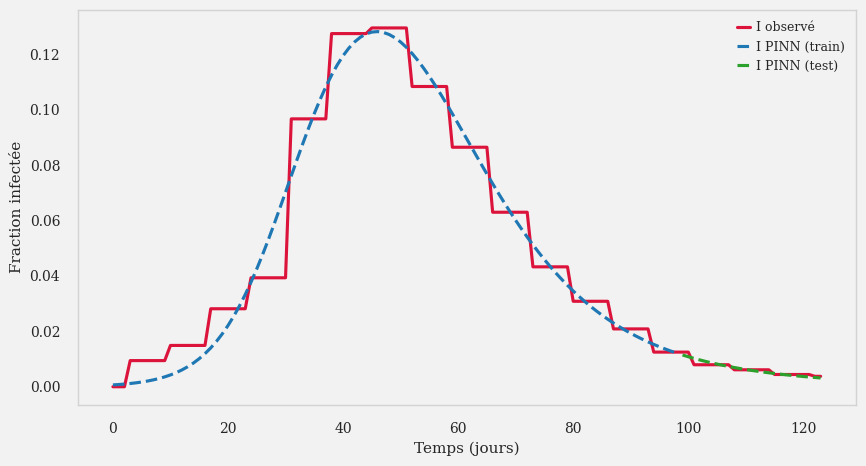

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ─── Visualisation + téléchargement du graphique I observé vs I PINN ───

# Configuration du style graphique
sns.set_theme(style="white", context="talk", palette="colorblind")
plt.rcParams.update({
    "figure.facecolor": "#f2f2f2", "axes.facecolor": "#f2f2f2",
    "axes.edgecolor": "lightgray", "axes.linewidth": 1.0,
    "font.family": "serif", "axes.titlesize": 13, "axes.labelsize": 11,
    "legend.fontsize": 9, "xtick.labelsize": 10, "ytick.labelsize": 10
})

# Création du répertoire de sortie
out_dir = pathlib.Path("PINN_outputs"); out_dir.mkdir(exist_ok=True)

# Tracé
plt.figure(figsize=(9,5))
plt.plot(jours,      np.concatenate([I_train.squeeze(), I_test.squeeze()]), label="I observé",   color="crimson")
plt.plot(jours[:idx_split], Ih_train.numpy().squeeze(), "--", label="I PINN (train)", color="tab:blue")
plt.plot(jours_test, Ih_test.numpy().squeeze(),        "--", label="I PINN (test)",  color="tab:green")
plt.xlabel("Temps (jours)")
plt.ylabel("Fraction infectée")
plt.legend(frameon=False)
plt.tight_layout()

# Sauvegarde PDF
pdf_path = out_dir / "I_real_vs_PINN.pdf"
plt.savefig(pdf_path, format="pdf", dpi=300, bbox_inches="tight", facecolor=plt.gcf().get_facecolor())
plt.show()

# Téléchargement
files.download(str(pdf_path))


In [ ]:
# 🔮 Prédiction future des compartiments SEIR (valeurs numériques)

# Étape 1 : Générer les temps futurs normalisés
T_future = 1.2    # prévision jusqu'à 20% au-delà de l'intervalle d'entraînement (si t ∈ [0,1])
N_future = 50     # nombre de points prédits
t_future = tf.linspace(1.0, T_future, N_future)[:, None]  # shape (N_future, 1)

# Étape 2 : Appeler le modèle sur t_future
Kf, If, Sf, Ef, Rf, _, _, _ = model(t_future)

# Étape 3 : Organiser les résultats dans un DataFrame
df_future = pd.DataFrame({
    "t_normalisé": t_future.numpy().squeeze(),
    "S(t)": Sf.numpy().squeeze(),
    "E(t)": Ef.numpy().squeeze(),
    "I(t)": If.numpy().squeeze(),
    "R(t)": Rf.numpy().squeeze()
})

# 🔍 Affichage des premières lignes
print(df_future.head(10))


   t_normalisé      S(t)      E(t)      I(t)      R(t)
0     1.000000  0.000195  0.000315  0.003179  0.996311
1     1.004082  0.000186  0.000303  0.003101  0.996410
2     1.008163  0.000178  0.000291  0.003025  0.996506
3     1.012245  0.000170  0.000280  0.002951  0.996599
4     1.016327  0.000162  0.000270  0.002879  0.996690
5     1.020408  0.000155  0.000259  0.002809  0.996777
6     1.024490  0.000148  0.000249  0.002740  0.996862
7     1.028571  0.000142  0.000240  0.002674  0.996944
8     1.032653  0.000135  0.000231  0.002610  0.997024
9     1.036735  0.000129  0.000222  0.002547  0.997102
